# MIT BIH DATABASE

In [1]:
#Importing Libaries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Input, Conv1D, DepthwiseConv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Defining Functions

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, DepthwiseConv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.layers import Input

#im_shape=(X_train.shape[1],1)

# Define the Depthwise Separable Convolution with Embedded Max Pooling (DSCEMP) layer
def depthwise_separable_conv_with_embedded_max_pooling(x, filters, kernel_size, dilation_rate,pool_size):
    # Depthwise Convolution
    x = DepthwiseConv1D(kernel_size=kernel_size, dilation_rate=dilation_rate, padding='valid')(x)
    
    # Embedded Max Pooling
    x = MaxPooling1D(pool_size=pool_size, strides=1, padding='valid')(x)
    
    # Pointwise Convolution
    x = Conv1D(filters=filters, kernel_size=1, activation='relu', padding='valid')(x)
    
    return x

# Define the Layer Decomposition with Single Channel Pooling (LDSCP) layer
def projection_layer(inputs, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='valid')(inputs)
    return x

# Define the Layer Decomposition with Dual Channel Pooling (LDDCP) layer
def weighted_global_average_pooling(inputs, filters, kernel_size):
    avg_pool = AveragePooling1D(pool_size=kernel_size, strides=1, padding='valid')(inputs)
    #x = Conv1D(filters=filters, kernel_size=1, activation='relu', padding='valid')(avg_pool)
    return avg_pool

# Stage 1

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Lambda, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def ultralight_ecg_net_1():
    inputs = Input(shape=(399, 1))

    # First Stage
    x = depthwise_separable_conv_with_embedded_max_pooling(inputs, filters=8, kernel_size=15, dilation_rate=4, pool_size=2)
    x = depthwise_separable_conv_with_embedded_max_pooling(x, filters=16, kernel_size=9, dilation_rate=3, pool_size=2)
    
    # Layer Decomposition with Single Channel Pooling (FC 1)
    x = projection_layer(x, filters=128, kernel_size=1)
    
    # Apply Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Apply L2 Normalization
    x = Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)
    
    # Fully-connected layer (FC 2)
    x = Dense(2, activation='softmax')(x)   
    
    model = Model(inputs=inputs, outputs=x)
    
    return model

In [5]:
model1 = ultralight_ecg_net_1()

In [6]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 399, 1)]          0         
                                                                 
 depthwise_conv1d (Depthwis  (None, 343, 1)            16        
 eConv1D)                                                        
                                                                 
 max_pooling1d (MaxPooling1  (None, 342, 1)            0         
 D)                                                              
                                                                 
 conv1d (Conv1D)             (None, 342, 8)            16        
                                                                 
 depthwise_conv1d_1 (Depthw  (None, 318, 8)            80        
 iseConv1D)                                                      
                                                             

In [7]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Data

In [8]:
train_df=pd.read_excel(r'C:\Users\Himanshu Singh\Desktop\Himanshu_TUB\Ultralight ECG\ULECG\Datasets\Exp1\MIT\Processed Data\Stage 1\MIT_BIH_Data_Stage_1_train.xlsx',header=None)

In [9]:
count=train_df[400].value_counts()
print(count)

400
0    37518
1     4458
Name: count, dtype: int64


In [10]:
c=train_df.groupby(400,group_keys=False).apply(lambda train_data : train_data.sample(1))

In [11]:
target_train=train_df[400]
y_train=to_categorical(target_train)

In [12]:
target_train.shape
y_train.shape

(41976, 2)

In [13]:
X_train=train_df.iloc[:,:399].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)

In [14]:
print(X_train.shape)
print(y_train.shape)
type(X_train)
type(y_train)

(41976, 399, 1)
(41976, 2)


numpy.ndarray

In [15]:
# Train the model on the training set
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)
history=model1.fit(X_train, y_train, epochs=40, batch_size=32, callbacks=[early_stop])

Epoch 1/40
1312/1312 [==============================] - 29s 21ms/step - loss: 0.2224 - accuracy: 0.9245
Epoch 2/40
1312/1312 [==============================] - 28s 21ms/step - loss: 0.1193 - accuracy: 0.9639
Epoch 3/40
1312/1312 [==============================] - 27s 21ms/step - loss: 0.1041 - accuracy: 0.9675
Epoch 4/40
1312/1312 [==============================] - 27s 21ms/step - loss: 0.0878 - accuracy: 0.9718
Epoch 5/40
1312/1312 [==============================] - 27s 21ms/step - loss: 0.0774 - accuracy: 0.9746
Epoch 6/40
1312/1312 [==============================] - 28s 21ms/step - loss: 0.0704 - accuracy: 0.9775
Epoch 7/40
1312/1312 [==============================] - 28s 21ms/step - loss: 0.0671 - accuracy: 0.9785
Epoch 8/40
1312/1312 [==============================] - 27s 21ms/step - loss: 0.0618 - accuracy: 0.9801
Epoch 9/40
1312/1312 [==============================] - 27s 21ms/step - loss: 0.0619 - accuracy: 0.9800
Epoch 10/40
1312/1312 [==============================] - 28s 21m

# Testing

In [16]:
test_df=pd.read_excel(r'C:\Users\Himanshu Singh\Desktop\Himanshu_TUB\Ultralight ECG\ULECG\Datasets\Exp1\MIT\Processed Data\Stage 1\MIT_BIH_Data_Stage_1_test.xlsx',header=None)

In [17]:
test_df.shape

(41974, 401)

In [18]:
count=test_df[400].value_counts()
print(count)

400
0    37483
1     4491
Name: count, dtype: int64


In [19]:
target_test=test_df[400]
y_test=to_categorical(target_test)

In [20]:
target_test.shape

(41974,)

In [21]:
X_test=test_df.iloc[:,:399].values
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [22]:
print(X_test.shape )
print(y_test.shape)
type(X_test)
type(y_test)

(41974, 399, 1)
(41974, 2)


numpy.ndarray

In [23]:
# Evaluate the model on the test dataset
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1312/1312 [==============================] - 11s 8ms/step - loss: 0.0355 - accuracy: 0.9884
Test Loss: 0.0355
Test Accuracy: 0.9884


In [24]:
# Prediction on test data
y_pred = model1.predict(X_test)

1312/1312 [==============================] - 10s 8ms/step


In [25]:
# Plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
class_names = ['N', 'A']

In [26]:
# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [27]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_pred_classes, y_true_classes)

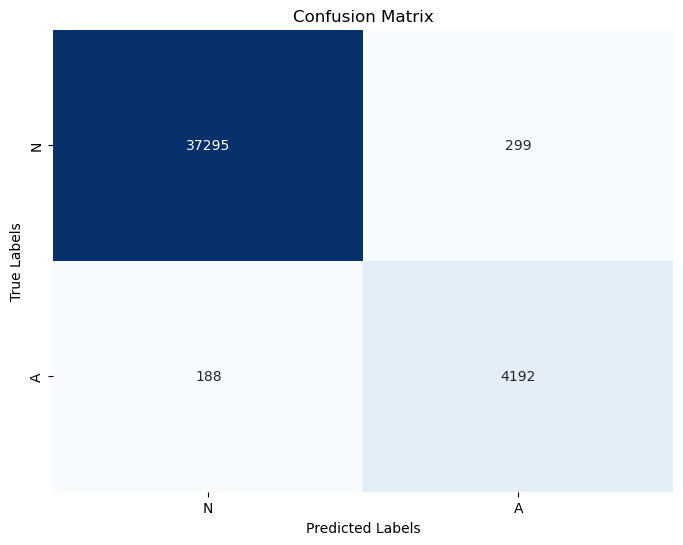

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Stage 2

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, DepthwiseConv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D
from keras.models import Model
from keras.layers import Input

im_shape=(X_train.shape[1],1)

# Define the Depthwise Separable Convolution with Embedded Max Pooling (DSCEMP) layer
def depthwise_separable_conv_with_embedded_max_pooling(x, filters, kernel_size, dilation_rate,pool_size):
    # Depthwise Convolution
    x = DepthwiseConv1D(kernel_size=kernel_size, dilation_rate=dilation_rate, padding='valid')(x)
    
    # Embedded Max Pooling
    x = MaxPooling1D(pool_size=pool_size, strides=1, padding='valid')(x)
    
    # Pointwise Convolution
    x = Conv1D(filters=filters, kernel_size=1, activation='relu', padding='valid')(x)
    
    return x

# Define the Layer Decomposition with Single Channel Pooling (LDSCP) layer
def projection_layer(inputs, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='valid')(inputs)
    return x

# Define the weighted average global pooling
def weighted_global_average_pooling(inputs, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=1, activation='linear', padding='valid')(inputs)
    x = GlobalAveragePooling1D()(x)
    return x

In [30]:
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model

def ultralight_ecg_net_2():
    inputs = Input(shape=(399, 1))
    
    # Second Stage
    x = depthwise_separable_conv_with_embedded_max_pooling(inputs, filters=16, kernel_size=15, dilation_rate=4, pool_size=4)
    x = depthwise_separable_conv_with_embedded_max_pooling(x, filters=32, kernel_size=9, dilation_rate=3, pool_size=2)
    
    # Layer Decomposition with Dual Channel Pooling (FC 1)
    x = projection_layer(x, filters=64, kernel_size=1)
    x1 = weighted_global_average_pooling(x, filters=64, kernel_size=31)
    x2 = GlobalMaxPooling1D()(x)
    
    concatenated_outputs = Concatenate()([x1, x2])
    
    # Fully-connected layer (FC 2)
    outputs = Dense(5, activation='softmax')(concatenated_outputs)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
model = ultralight_ecg_net_2()

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 399, 1)]             0         []                            
                                                                                                  
 depthwise_conv1d_2 (Depthw  (None, 343, 1)               16        ['input_2[0][0]']             
 iseConv1D)                                                                                       
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 340, 1)               0         ['depthwise_conv1d_2[0][0]']  
 g1D)                                                                                             
                                                                                            

In [33]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training

In [34]:
train_df=pd.read_excel(r'C:\Users\Himanshu Singh\Desktop\Himanshu_TUB\Ultralight ECG\ULECG\Datasets\Exp1\MIT\Processed Data\Stage 2\MIT_BIH_Data_Stage_2_train.xlsx',header=None)

In [35]:
count=train_df[400].value_counts()
print(count)

400
0    37518
2     3563
3      876
4       17
1        2
Name: count, dtype: int64


In [36]:
c=train_df.groupby(400,group_keys=False).apply(lambda train_data : train_data.sample(1))

In [37]:
target_train=train_df[400]
y_train=to_categorical(target_train)

In [38]:
target_train.shape
y_train.shape

(41976, 5)

In [39]:
X_train=train_df.iloc[:,:399].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)

In [40]:
print(X_train.shape)
print(y_train.shape)
type(X_train)
type(y_train)

(41976, 399, 1)
(41976, 5)


numpy.ndarray

In [41]:
# Train the model on the training set
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)
history=model.fit(X_train, y_train, epochs=40, batch_size=32, callbacks=[early_stop])

Epoch 1/40
1312/1312 [==============================] - 38s 28ms/step - loss: 0.2895 - accuracy: 0.9209
Epoch 2/40
1312/1312 [==============================] - 37s 28ms/step - loss: 0.1832 - accuracy: 0.9451
Epoch 3/40
1312/1312 [==============================] - 38s 29ms/step - loss: 0.1462 - accuracy: 0.9556
Epoch 4/40
1312/1312 [==============================] - 37s 28ms/step - loss: 0.1236 - accuracy: 0.9626
Epoch 5/40
1312/1312 [==============================] - 41s 32ms/step - loss: 0.1076 - accuracy: 0.9675
Epoch 6/40
1312/1312 [==============================] - 42s 32ms/step - loss: 0.0970 - accuracy: 0.9709
Epoch 7/40
1312/1312 [==============================] - 42s 32ms/step - loss: 0.0922 - accuracy: 0.9731
Epoch 8/40
1312/1312 [==============================] - 39s 29ms/step - loss: 0.0866 - accuracy: 0.9747
Epoch 9/40
1312/1312 [==============================] - 42s 32ms/step - loss: 0.0824 - accuracy: 0.9763
Epoch 10/40
1312/1312 [==============================] - 41s 31m

# Testing

In [58]:
test_df=pd.read_excel(r'C:\Users\Himanshu Singh\Desktop\Himanshu_TUB\Ultralight ECG\ULECG\Datasets\Exp1\MIT\Processed Data\Stage 2\MIT_BIH_Data_Stage_2_test.xlsx',header=None)

In [43]:
test_df.shape

(41974, 402)

In [44]:
count=test_df[400].value_counts()
print(count)

400
0    37483
2     3566
3      908
4       16
1        1
Name: count, dtype: int64


In [45]:
target_test=test_df[400]
y_test=to_categorical(target_test)

In [46]:
target_test.shape

(41974,)

In [47]:
X_test=test_df.iloc[:,:399].values
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [48]:
print(X_test.shape )
print(y_test.shape)
type(X_test)
type(y_test)

(41974, 399, 1)
(41974, 5)


numpy.ndarray

In [49]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1312/1312 [==============================] - 13s 10ms/step - loss: 0.0425 - accuracy: 0.9886
Test Loss: 0.0425
Test Accuracy: 0.9886


In [50]:
# Prediction on test data
y_pred = model.predict(X_test)

1312/1312 [==============================] - 13s 9ms/step


In [51]:
# Plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
class_names = ['N', 'S', 'V', 'F', 'Q']

In [52]:
# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [53]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

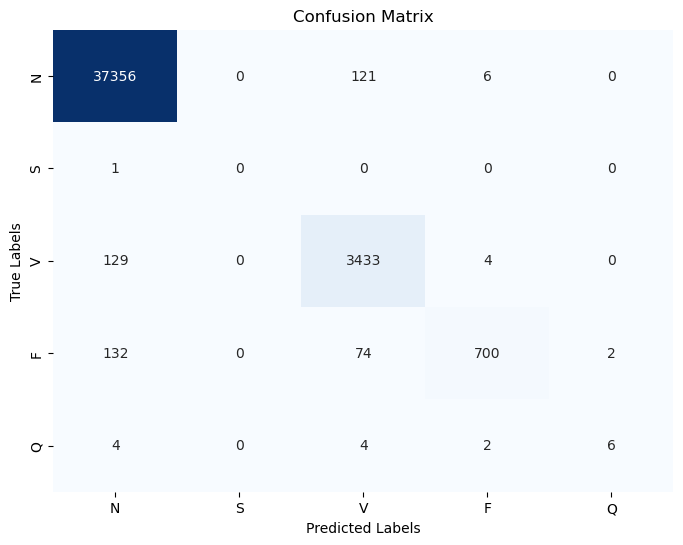

In [54]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [55]:
from sklearn.metrics import classification_report
# Print classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           N       0.99      1.00      0.99     37483
           S       0.00      0.00      0.00         1
           V       0.95      0.96      0.95      3566
           F       0.98      0.77      0.86       908
           Q       0.75      0.38      0.50        16

    accuracy                           0.99     41974
   macro avg       0.73      0.62      0.66     41974
weighted avg       0.99      0.99      0.99     41974



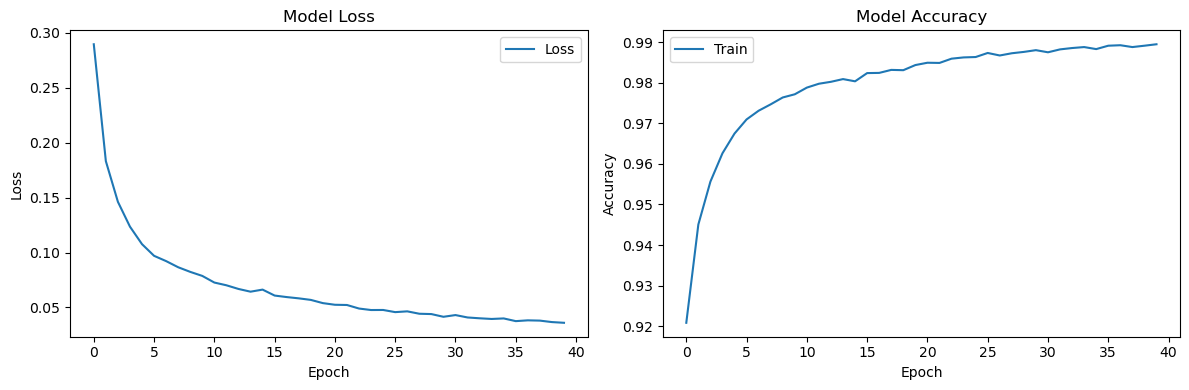

In [56]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object from your model training
# history = model.fit(...)

# Plotting the loss curves
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
#plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
#plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# K Fold Cross Validation

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Conv1D, DepthwiseConv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define a function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_val, y_val):
    model = ultralight_ecg_net_2()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stop = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32, callbacks=[early_stop])

    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

    return model


ModuleNotFoundError: No module named 'keras.utils.np_utils'

In [ ]:
# K-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train.argmax(axis=1))):
    print(f"Fold {fold + 1}/{k}")
    
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = train_and_evaluate_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    y_pred_fold = model.predict(X_val_fold)
    y_pred_fold_classes = np.argmax(y_pred_fold, axis=1)
    y_true_fold_classes = np.argmax(y_val_fold, axis=1)

    # Compute and print classification report for this fold
    print(classification_report(y_true_fold_classes, y_pred_fold_classes))
    class_names = ['N', 'S', 'V', 'F', 'Q']
    # Plot confusion matrix for this fold
    conf_matrix = confusion_matrix(y_true_fold_classes, y_pred_fold_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()